
<h1 align=center><font size = 5>Hacktiv8-PTP Python For Data Science // S.15 // Model Deployment</font></h1>

Data scientists often have to communicate results to other people. In my case, my supervisors might want to see some numbers or I have to write up the main insights of some work for a paper. This is pretty straightforward — I just copy and paste into an email or a Latex document. But what if I want to send someone an actual model that I have trained, so that they can either evaluate or use it? If the person in question is technical enough, then I can just save the model to disk and email that, along with some Jupyter notebooks.

But what if you want someone in marketing to try out a model, or you want to share it with friends who might find it interesting? In this case, you’ll need to make your code accessible to them in a way they are familiar with.

The three parts to this labs are:
- Creating a simple model that can be deployed to the web, where users can input variables to get predictions.
- Building the components needed by Flask microframework to create a web app.
- Deploying the final web app using the Heroku platform.

## Creating Model for Deployment

You can deploy from model you've build before; or if you want a new model, follow step below. Grab data used from [here](https://www.kaggle.com/benroshan/factors-affecting-campus-placement).

The data set consists of Placement data of students in a XYZ campus. It includes secondary and higher secondary school percentage and specialization. It also includes degree specialization, type and Work experience and salary offers to the placed students

In [3]:
!pip install pandas_profiling

### Importing Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import pickle

%matplotlib inline

In [14]:
data = pd.read_csv('dataset/Placement_Data_Full_Class.csv')

# Remove Serial Number
data.drop("sl_no", axis=1, inplace=True)

### Examining Dataset

In [15]:
data.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


Inference

- We have Gender and Educational qualification data
- We have all the educational performance(score) data
- We have the status of placement and salary details
- We can expect null values in salary as candidates who weren't placed would have no salary
- Status of placement is our target variable rest of them are independent variable except salary

In [16]:
print ("The shape of the  data is (row, column):"+ str(data.shape))
print (data.info())

The shape of the  data is (row, column):(215, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    object 
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  status          215 non-null    object 
 13  salary          148 non-null    float64
dtypes: float64(6), object(8)
memory usage: 23.6+ KB
None


In [19]:
report = data.profile_report(title='Campus Placement Data - Report',
                             progress_bar=False)
report

# Uncomment syntax below to make new html file

report.to_file(output_file='output.html') # dapat output secara terpisah

- 67 Missing values in Salary for students who didn't get placed. NaN Value needs to be filled.
- Data is not scaled. Salary column ranges from 200k-940k, rest of numerical columns are percentages.
- 300k at 75th Percentile goes all the way up to 940k max, in Salary (high skewnwss). Thus, outliers at high salary end.

### Data Cleaning / Handling missing values

In [20]:
data['salary'].fillna(value=0, inplace=True)
print('Salary column with null values:',
      data['salary'].isnull().sum(), sep = '\n')

Salary column with null values:
0


### Exploring Data by each Features

In [21]:
"""
Feature: Gender

Does gender affect placements?
"""

data.gender.value_counts()

M    139
F     76
Name: gender, dtype: int64

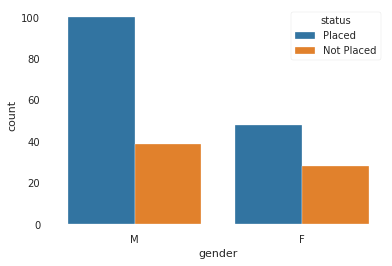

In [13]:
sns.countplot("gender", hue="status", data=data)
plt.show()

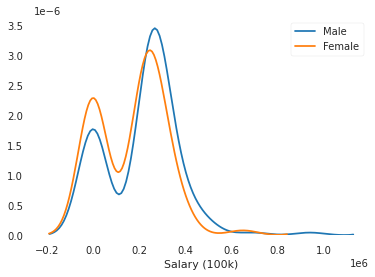

In [16]:
sns.kdeplot(data.salary[data.gender=="M"])
sns.kdeplot(data.salary[data.gender=="F"])
plt.legend(["Male", "Female"])
plt.xlabel("Salary (100k)")
plt.show()

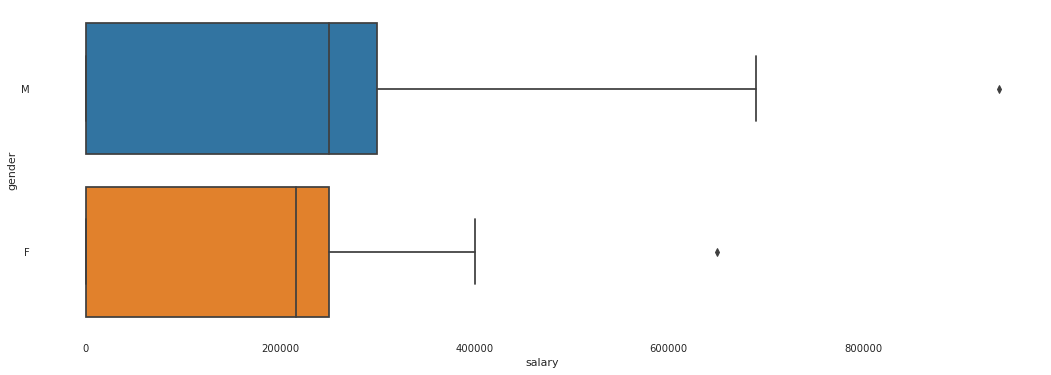

In [15]:
plt.figure(figsize =(18,6))
sns.boxplot("salary", "gender", data=data)
plt.show()

Insights

- We have samples of 139 Male studets and 76 Female students.
- 30 Female and 40 Male students are not placed. Male students have comparatively higher placemets.
- Male students are offered slightly greater salary than female on an average.

In [ ]:
"""
Feature: ssc_p (Secondary Education percentage), ssc_b (Board Of Education)

Does Secondary Education affect placements?
"""

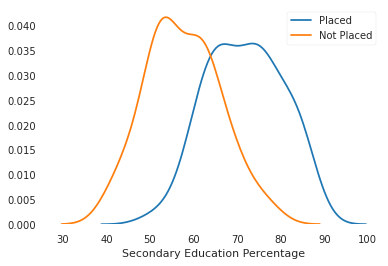

In [17]:
sns.kdeplot(data.ssc_p[data.status=="Placed"])
sns.kdeplot(data.ssc_p[data.status=="Not Placed"])
plt.legend(["Placed", "Not Placed"])
plt.xlabel("Secondary Education Percentage")
plt.show()

- All students with Secondary Education Percentage above 90% are placed
- All students with Secondary Education Percentage below 50% are not-placed
- Students with good Secondary Education Percentage are placed on average.

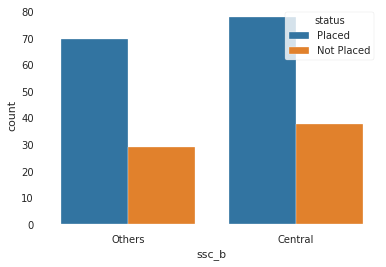

In [18]:
sns.countplot("ssc_b", hue="status", data=data)
plt.show()

Board Of Education does not affect Placement Status much

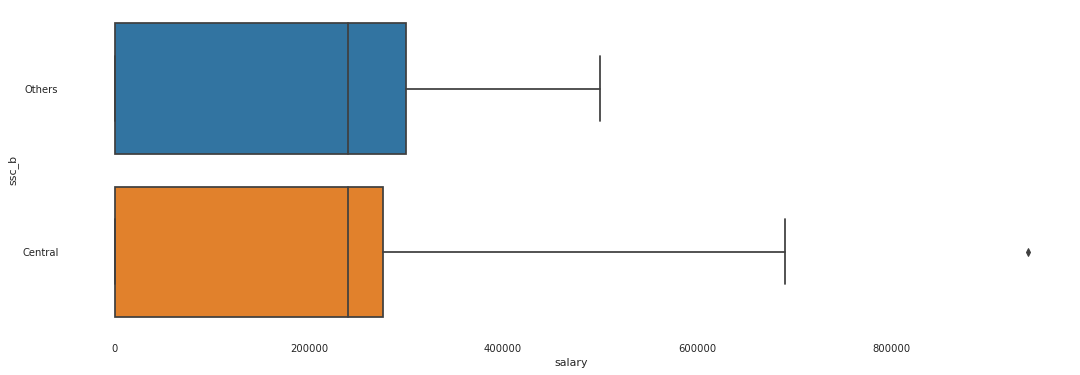

In [19]:
plt.figure(figsize =(18,6))
sns.boxplot("salary", "ssc_b", data=data)
plt.show()

Outliers on both, but students from Central Board are getting the highly paid jobs.

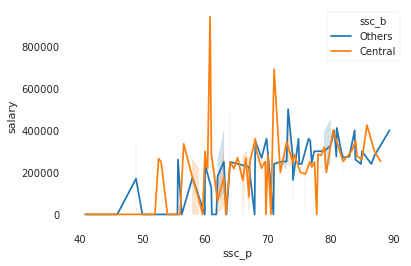

In [20]:
sns.lineplot("ssc_p", "salary", hue="ssc_b", data=data)
plt.show()

No specific pattern (correlation) between Secondary Education Percentage and Salary.
Board of Education is Not Affecting Salary

You can make your own graph from here.

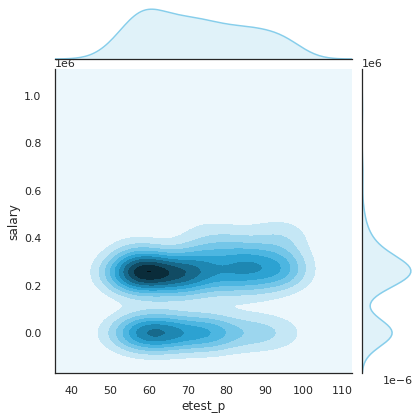

In [22]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(style="white", color_codes=True)
sns.jointplot(x=data["etest_p"], y=data["salary"], kind='kde', color="skyblue")

plt.show()

- Most of the candidates scored around 60 percentage got a decent package of around 3 lakhs PA
- Not many candidates received salary more than 4 lakhs PA
- The bottom dense part shows the candidates who were not placed

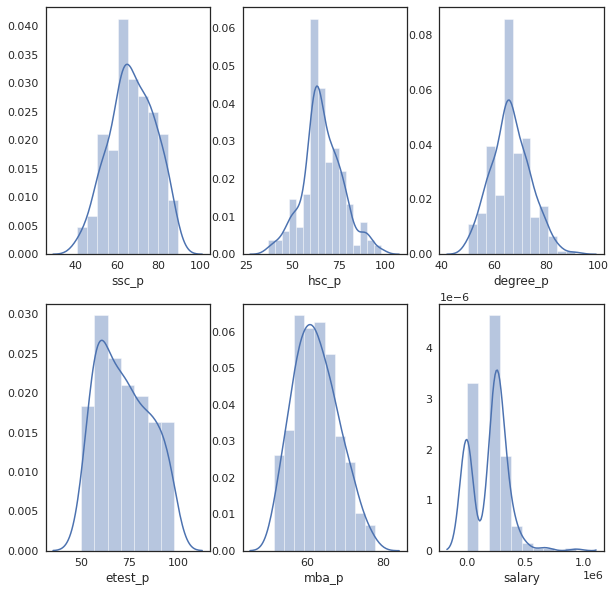

In [24]:
plt.figure(figsize = (15, 7))
plt.style.use('seaborn-white')
plt.subplot(231)
sns.distplot(data['ssc_p'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(232)
sns.distplot(data['hsc_p'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(233)
sns.distplot(data['degree_p'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(234)
sns.distplot(data['etest_p'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(235)
sns.distplot(data['mba_p'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(236)
sns.distplot(data['salary'])
fig = plt.gcf()
fig.set_size_inches(10,10)

- All the distributions follow normal distribution except salary feature
- Most of the candidates educational performances are between 60-80%
- Salary distribution got outliers where few have got salary of 7.5L and 10L PA

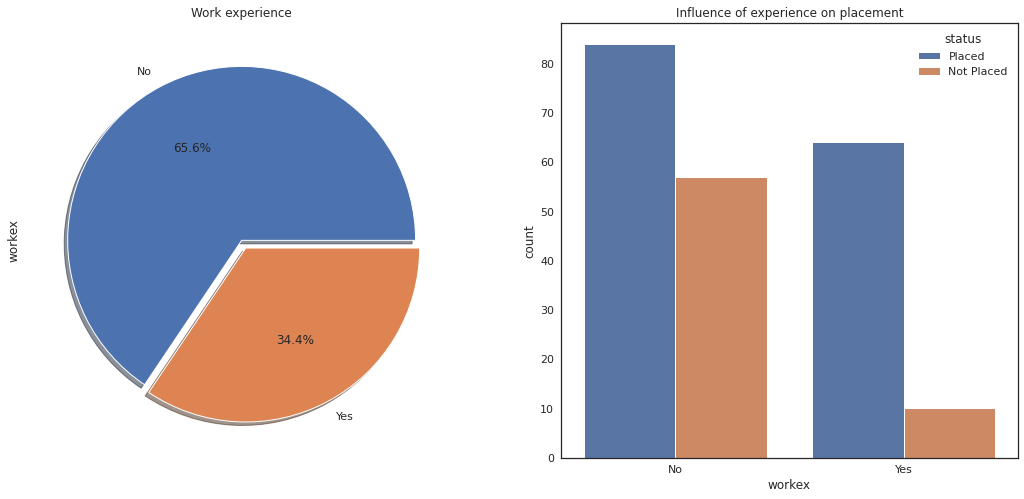

In [27]:
plt.style.use('seaborn-white')
f,ax=plt.subplots(1,2,figsize=(18,8))
data['workex'].value_counts().plot.pie(explode=[0,0.05], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Work experience')
sns.countplot(x = 'workex',hue = "status",data = data)
ax[1].set_title('Influence of experience on placement')

plt.show()

- We have nearly 66.2% of candidates who never had any work experience
- Candidates who never had work experience have got hired more than the ones who had experience
- We can conclude that work experience doesn't influence a candidate in the recruitment process

###  Preprocessing data for classfication models

In [22]:
from sklearn.preprocessing import LabelEncoder

object_cols = ['gender','workex','specialisation','status']

label_encoder = LabelEncoder()
for col in object_cols:
    data[col] = label_encoder.fit_transform(data[col])
data.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,0,55.0,1,58.80,1,270000.0
1,1,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,1,86.5,0,66.28,1,200000.0
2,1,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,0,75.0,0,57.80,1,250000.0
3,1,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,0,66.0,1,59.43,0,0.0
4,1,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,0,96.8,0,55.50,1,425000.0


In [23]:
# Library imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [24]:
# Seperating Features and Target
X = data[['ssc_p', 'hsc_p', 'degree_p', 'etest_p']]
y = data['status']

In [25]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [26]:
# Decision Tree
dtree = DecisionTreeClassifier(criterion='entropy')
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.7538461538461538
              precision    recall  f1-score   support

           0       0.86      0.46      0.60        26
           1       0.73      0.95      0.82        39

    accuracy                           0.75        65
   macro avg       0.79      0.71      0.71        65
weighted avg       0.78      0.75      0.73        65



In [27]:
#Using Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.7846153846153846
              precision    recall  f1-score   support

           0       1.00      0.46      0.63        26
           1       0.74      1.00      0.85        39

    accuracy                           0.78        65
   macro avg       0.87      0.73      0.74        65
weighted avg       0.84      0.78      0.76        65



In [28]:
#Using Logistic Regression

LogR = LogisticRegression(solver='lbfgs')
LogR.fit(X_train, y_train)

y_pred = LogR.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.8
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        26
           1       0.75      1.00      0.86        39

    accuracy                           0.80        65
   macro avg       0.88      0.75      0.76        65
weighted avg       0.85      0.80      0.78        65



### Getting ready for deployment

**Pickle**

Python pickle module is used for serializing and de-serializing a Python object structure. Any object in Python can be pickled so that it can be saved on disk. What pickle does is that it 'serializes' the object first before writing it to file. Pickling is a way to convert a python object (list, dict, etc.) into a character stream. The idea is that this character stream contains all the information necessary to reconstruct the object in another python script.

In [30]:
pickle.dump(LogR, open('model_classifier.pkl','wb'))

In [31]:
!pip install flask

## Creating web app with Flask

Make sure flask is installed with `pip install flask`.

A minimal Flask application looks something like this:

```py
from flask import Flask
app = Flask(__name__)

@app.route('/')
def hello_world():
    return 'Hello, World!'
```

So what did that code do?

- First we imported the `Flask` class. An instance of this class will be our WSGI application.
- Next we create an instance of this class. The first argument is the name of the application’s module or package. If you are using a single module (as in this example), you should use `__name__` because depending on if it’s started as application or imported as module the name will be different (`'__main__'` versus the actual import name). This is needed so that Flask knows where to look for templates, static files, and so on.
- We then use the `route()` decorator to tell Flask what URL should trigger our function.
- The function is given a name which is also used to generate URLs for that particular function, and returns the message we want to display in the user’s browser.

Just save it as `hello.py` or something similar. Make sure to not call your application `flask.py` because this would conflict with Flask itself.

To run the application you can either use the flask command or python’s -m switch with Flask. Before you can do that you need to tell your terminal the application to work with by exporting the FLASK_APP environment variable:

```sh
$ export FLASK_APP=hello.py
$ flask run
 * Running on http://127.0.0.1:5000/
```

This launches a very simple builtin server, which is good enough for testing but probably not what you want to use in production.

Now head over to http://127.0.0.1:5000/, and you should see your hello world greeting.

### Debug Mode

The flask script is nice to start a local development server, but you would have to restart it manually after each change to your code. That is not very nice and Flask can do better. If you enable debug support the server will reload itself on code changes, and it will also provide you with a helpful debugger if things go wrong.

To enable all development features (including debug mode) you can export the `FLASK_ENV` environment variable and set it to `development` before running the server:

```sh
$ export FLASK_ENV=development
$ flask run
```

(On Windows you need to use set instead of export.)

This does the following things:

- it activates the debugger
- it activates the automatic reloader
- it enables the debug mode on the Flask application.

You can also control debug mode separately from the environment by exporting `FLASK_DEBUG=1`.

### Routing

Modern web applications use meaningful URLs to help users. Users are more likely to like a page and come back if the page uses a meaningful URL they can remember and use to directly visit a page.

Use the `route()` decorator to bind a function to a URL.

```py
@app.route('/')
def index():
    return 'Index Page'

@app.route('/hello')
def hello():
    return 'Hello, World'
```

You can do more! You can make parts of the URL dynamic and attach multiple rules to a function.

### Variable Rules

You can add variable sections to a URL by marking sections with `<variable_name>`. Your function then receives the <variable_name> as a keyword argument. Optionally, you can use a converter to specify the type of the argument like `<converter:variable_name>`.

```py
from markupsafe import escape

@app.route('/user/<username>')
def show_user_profile(username):
    # show the user profile for that user
    return 'User %s' % escape(username)

@app.route('/post/<int:post_id>')
def show_post(post_id):
    # show the post with the given id, the id is an integer
    return 'Post %d' % post_id

@app.route('/path/<path:subpath>')
def show_subpath(subpath):
    # show the subpath after /path/
    return 'Subpath %s' % escape(subpath)
```

### HTTP Methods

Web applications use different HTTP methods when accessing URLs. You should familiarize yourself with the HTTP methods as you work with Flask. By default, a route only answers to `GET` requests. You can use the methods argument of the `route()` decorator to handle different HTTP methods.

```py
from flask import request

@app.route('/login', methods=['GET', 'POST'])
def login():
    if request.method == 'POST':
        return do_the_login()
    else:
        return show_the_login_form()
```

If GET is present, Flask automatically adds support for the `HEAD` method and handles `HEAD` requests according to the HTTP RFC. Likewise, OPTIONS is automatically implemented for you.

### Static Files

Dynamic web applications also need static files. That’s usually where the CSS and JavaScript files are coming from. Ideally your web server is configured to serve them for you, but during development Flask can do that as well. Just create a folder called static in your package or next to your module and it will be available at /static on the application.

To generate URLs for static files, use the special 'static' endpoint name:

`url_for('static', filename='style.css')`

The file has to be stored on the filesystem as static/style.css.

### Rendering Templates

Generating HTML from within Python is not fun, and actually pretty cumbersome because you have to do the HTML escaping on your own to keep the application secure. Because of that Flask configures the Jinja2 template engine for you automatically.

To render a template you can use the `render_template()` method. All you have to do is provide the name of the template and the variables you want to pass to the template engine as keyword arguments. Here’s a simple example of how to render a template:

```py
from flask import render_template

@app.route('/hello/')
@app.route('/hello/<name>')
def hello(name=None):
    return render_template('hello.html', name=name)
```

Flask will look for templates in the templates folder. So if your application is a module, this folder is next to that module, if it’s a package it’s actually inside your package:

Case 1: a module:

```dir
/application.py
/templates
    /hello.html
```

Case 2: a package:

```dir
/application
    /__init__.py
    /templates
        /hello.html
```

For templates you can use the full power of Jinja2 templates. Head over to the official Jinja2 Template Documentation for more information.

Here is an example template:

```html
<!doctype html>
<title>Hello from Flask</title>
{% if name %}
  <h1>Hello {{ name }}!</h1>
{% else %}
  <h1>Hello, World!</h1>
{% endif %}
```

Inside templates you also have access to the request, session and g 1 objects as well as the get_flashed_messages() function.

Templates are especially useful if inheritance is used. Basically template inheritance makes it possible to keep certain elements on each page (like header, navigation and footer).

Automatic escaping is enabled, so if name contains HTML it will be escaped automatically. If you can trust a variable and you know that it will be safe HTML (for example because it came from a module that converts wiki markup to HTML) you can mark it as safe by using the Markup class or by using the |safe filter in the template.

### Make our own Flask

There are several things we need to put together for the web app. The first two are:

- The Python code that will load our model, get user input from a web form, do predictions, return results.
- The HTML templates that flask with render. These allow the user to input their own data and will present the results.

The app will initially be structured like this:

```dir
webapp/
    ├── model/
    │   └── model_classifier.pkl
    ├── templates/
    │   └── main.html
    └── app.py
```

We’ll first create extremely an basic `app.py` and `main.html`, to demonstrate how flask works. We will expand these later on to suit our needs.

### app.py

This is the core of your web app. It’s what will run on the Heroku server, send out web pages and process input from users.

In flask, URLs get routed to different functions. Here, you can see that going to the base URL (e.g. www.ardhiraka.com) will trigger the `main()` function. This function simply serves up the `main.html` file, the location of which was specified when app was created. You can set up all sorts of routes for logging in, displaying data or similar.

```py
import flask

app = flask.Flask(__name__, template_folder='templates')

@app.route('/')
def main():
    return(flask.render_template('main.html'))
if __name__ == '__main__':
    app.run()
```

### main.html

This is what the template file looks like at the moment. All it does is display a simple message. We’ll edit this later on to suit our needs.

```html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>H8 Model Deployment</title>
</head>
<body>
    <h1>Welcome to My First Flask Apps!</h1>
</body>
</html>
```

### Running the test app

To start up flask on your local machine, make sure you are in the webapp folder and run the command: `flask run`.

This will launch your app locally, at http://127.0.0.1:5000/.

## Ready for Deployment

### Setup

In this step you’ll install the Heroku Command Line Interface (CLI). You use the CLI to manage and scale your applications, provision add-ons, view your application logs, and run your application locally.

Download and run the installer for your platform from [here](https://devcenter.heroku.com/articles/heroku-cli).

Once installed, you can use the heroku command from your command shell.

On Windows, start the Command Prompt (cmd.exe) or Powershell to access the command shell.

Use the `heroku login` command to log in to the Heroku CLI.

This command opens your web browser to the Heroku login page. If your browser is already logged in to Heroku, simply click the `Log in` button displayed on the page.

This authentication is required for both the heroku and git commands to work correctly.

### Prepare the app

In this step, you will prepare a simple application that can be deployed.

To clone the sample application so that you have a local version of the code that you can then deploy to Heroku.

### Deploy the app

In this step you will deploy the app to Heroku.

Create an app on Heroku, which prepares Heroku to receive your source code:

`heroku create`

By default, this will make an app with a random name. If you want to choose your own name, simply pass it as an argument. For example:

`heroku create h8-model`

When you create an app, a git remote (called `heroku`) is also created and associated with your local git repository.

Heroku generates a random name (in this case `serene-caverns-82714`) for your app, or you can pass a parameter to specify your own app name.

Now deploy your code:

`git push heroku master`

The application is now deployed. Ensure that at least one instance of the app is running:

`heroku ps:scale web=1`

Now visit the app at the URL generated by its app name. As a handy shortcut, you can open the website as follows:

`heroku open`

